Modification des Fonctions de Traçage : C'est l'étape cruciale. Les fonctions partie_electroaimant.tracer_ensemble_trajectoires et deviation.tracer_ensemble_trajectoires doivent être légèrement modifiées pour pouvoir dessiner sur un axe Matplotlib existant fourni par l'interface Tkinter, au lieu de créer leur propre figure et d'appeler plt.show().

Exemple de modification pour partie_electroaimant.py :

In [1]:
# Dans partie_electroaimant.py
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as constants
# ... (classe particule, etc.)

# Modifiez/Ajoutez une fonction comme celle-ci :
def tracer_ensemble_trajectoires(rapports_masse_charge_particules, vitesse_initiale, Bz, x_min, x_max, ax=None):
    """
    Trace les trajectoires de plusieurs particules.
    Si ax est fourni, trace dessus, sinon crée une nouvelle figure.
    """
    create_figure = ax is None
    if create_figure:
        fig, ax = plt.subplots(figsize=(10, 8)) # Crée une figure si non fournie

    # Conversion kg/C en u/e pour l'affichage (approximatif si besoin)
    def format_label(mq_ratio_si):
         # Conversion simple pour label (peut être affinée)
         mass_u_approx = mq_ratio_si * constants.e / constants.u
         return f"m/q ≈ {mass_u_approx:.2f} u/e"

    particules = [particule(mq, vitesse_initiale) for mq in rapports_masse_charge_particules]
    all_x_max_plot = [] # Pour ajuster les limites x si nécessaire

    for i, p in enumerate(particules):
         # Assurez-vous que la trajectoire ne calcule que jusqu'à x_max
         actual_x_max = x_max # Ou une autre logique si besoin
         x, y = p.trajectoire(Bz, x_min, actual_x_max)
         label = format_label(p.mq_ratio) # Utiliser le ratio m/q SI
         ax.plot(x, y, label=label)
         if len(x) > 0:
            all_x_max_plot.append(x[-1]) # Garder trace du max x atteint

    ax.set_xlabel("Position x (m)")
    ax.set_ylabel("Position y (m)")
    ax.set_title(f"Déviation Magnétique (Bz = {Bz:.3e} T, v0 = {vitesse_initiale:.2e} m/s)")
    ax.legend()
    ax.grid(True)
    ax.axhline(0, color='grey', lw=0.5)
    ax.axvline(0, color='grey', lw=0.5)
    # Ajuster les limites si nécessaire (optionnel)
    # if all_x_max_plot:
    #     ax.set_xlim(x_min, max(all_x_max_plot) * 1.1)

    if create_figure:
        plt.show() # Affiche seulement si aucune axe n'était fourni

Exemple de modification pour deviation.py :

In [2]:
# Dans deviation.py
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as constants
# ... (calcul_champ_electrique, classe particule, etc.)

# Modifiez/Ajoutez une fonction comme celle-ci :
def tracer_ensemble_trajectoires(masse_charge_particules_ueV, vitesse_initiale, angle_initial_rad, hauteur_initiale, E, ax=None):
    """
    Trace les trajectoires de plusieurs particules dans un champ E.
    masse_charge_particules_ueV: liste de tuples [(masse_u, charge_eV), ...]
    Si ax est fourni, trace dessus, sinon crée une nouvelle figure.
    """
    create_figure = ax is None
    if create_figure:
        fig, ax = plt.subplots(figsize=(10, 6))

    particules = [particule(mc, vitesse_initiale, angle_initial_rad, hauteur_initiale) for mc in masse_charge_particules_ueV]

    all_x_contact = []
    valid_trajectories = 0
    for p in particules:
        try:
            x_contact = p.point_contact(E)
            all_x_contact.append(x_contact)
            x, y = p.trajectoire(E, 0, x_contact) # Trace jusqu'au contact
            label = f"{p.m} u, {p.c} eV"
            ax.plot(x, y, label=label)
            # angle_incident = p.angle_incident(E) # Calcul si besoin
            # print(f"Particule {label}: x_contact={x_contact:.3f} m, angle_inc={np.degrees(angle_incident):.1f}°")
            valid_trajectories += 1
        except ValueError as e:
            print(f"Avertissement: Impossible de tracer {p.m}u, {p.c}eV - {e}")
            all_x_contact.append(0) # Pour que max() fonctionne

    if not valid_trajectories:
         ax.text(0.5, 0.5, "Aucune particule n'atteint la plaque\navec ces paramètres.",
                 horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
         # Fix limits for empty plot
         ax.set_xlim(0, 0.1)
         ax.set_ylim(0, hauteur_initiale * 1.1)

    else:
        max_x_plot = max(all_x_contact) * 1.2 if any(x > 0 for x in all_x_contact) else 0.1
        ax.plot([0, max_x_plot], [0, 0], c='black', linewidth=3, label='Échantillon (y=0)')

        # Basic auto-zoom based on contact points and initial height
        zoom_target_x = np.mean([x for x in all_x_contact if x > 0]) if any(x > 0 for x in all_x_contact) else 0
        zoom_factor_x = max(all_x_contact) if any(x > 0 for x in all_x_contact) else 0.1

        ax.set_xlim(-0.05 * zoom_factor_x, max(max_x_plot, 0.1)) # Un peu avant x=0
        ax.set_ylim(-0.05 * hauteur_initiale, hauteur_initiale * 1.1) # Un peu sous y=0

    ax.set_xlabel("Position x (m)")
    ax.set_ylabel("Position y (m)")
    ax.set_title(f"Déviation Électrique (E = {E:.2e} V/m, v0={vitesse_initiale:.2e} m/s, θ₀={np.degrees(angle_initial_rad):.1f}°)")
    ax.legend()
    ax.grid(True)


    if create_figure:
        plt.show()

# Assurez-vous que la classe particule dans deviation.py utilise bien les constantes eV et u
# Exemple dans __init__ de la classe particule de deviation.py:
# self.m = masse_charge[0] # Masse en u
# self.c = masse_charge[1] # Charge en eV
# self.m_kg = masse_charge[0] * constants.u
# self.q_coulomb = masse_charge[1] * constants.e
# self.mq = self.m_kg / self.q_coulomb if self.q_coulomb != 0 else float('inf') # kg/C
# ... le reste utilise self.mq, self.vo, self.angle, self.height

Code main.py amélioré :

KeyboardInterrupt: 

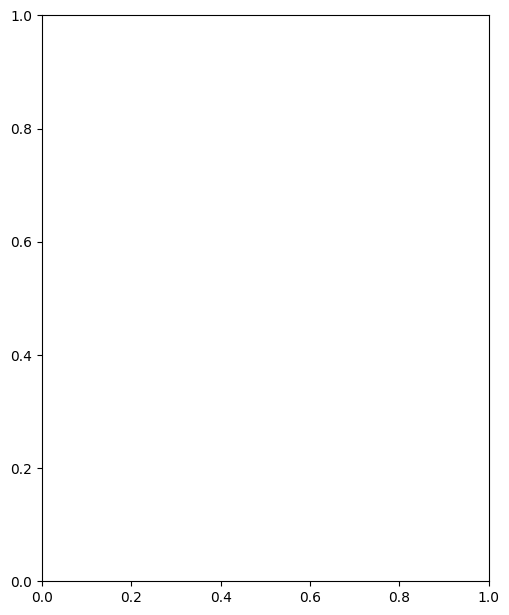

In [3]:
import sys
import tkinter as tk
from tkinter import ttk, messagebox, font
import numpy as np
import scipy.constants as constants
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk

# Permettre l'import des fichiers (ajustez les chemins si nécessaire)
# Suppose que le script main.py est dans le dossier parent de SIMS
sys.path.append("./SIMS/Partie Bleue (accélération)/Code")
sys.path.append("./SIMS/Partie Verte (déviation magnétique)/Code")

try:
    import deviation
    import partie_electroaimant
except ImportError as e:
    print(f"Erreur d'importation: {e}")
    print("Assurez-vous que les chemins sys.path sont corrects et que les fichiers existent.")
    sys.exit(1)


class ParticleApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Simulateur SIMS - Déviations")
        self.root.geometry("1000x800") # Taille initiale

        # Style
        style = ttk.Style()
        style.theme_use('clam') # Ou 'alt', 'default', 'classic'
        style.configure("TButton", padding=6, relief="flat", background="#ccc")
        style.configure("TLabelframe.Label", font=('Helvetica', 12, 'bold'))
        style.configure("TLabel", padding=2)
        style.configure("Treeview.Heading", font=('Helvetica', 10, 'bold'))

        # Liste pour stocker les données des particules {'mass_u': float, 'charge_e': float}
        self.particles_data = []

        # --- Structure principale ---
        main_paned_window = ttk.PanedWindow(root, orient=tk.HORIZONTAL)
        main_paned_window.pack(fill=tk.BOTH, expand=True)

        # --- Panneau de contrôle (gauche) ---
        control_panel = ttk.Frame(main_paned_window, width=350)
        main_paned_window.add(control_panel, weight=1)

        # --- Section Particules ---
        particle_frame = ttk.LabelFrame(control_panel, text="Gestion des Particules")
        particle_frame.pack(pady=10, padx=10, fill=tk.X)
        self.create_particle_widgets(particle_frame)

        # --- Section Onglets Simulations ---
        self.notebook = ttk.Notebook(control_panel)
        self.notebook.pack(pady=10, padx=10, fill=tk.BOTH, expand=True)

        self.mag_tab = ttk.Frame(self.notebook)
        self.elec_tab = ttk.Frame(self.notebook)

        self.notebook.add(self.mag_tab, text='Déviation Magnétique')
        self.notebook.add(self.elec_tab, text='Déviation Électrique')

        self.create_magnetic_widgets(self.mag_tab)
        self.create_electric_widgets(self.elec_tab)

        # --- Panneau de Plot (droite) ---
        plot_panel = ttk.Frame(main_paned_window)
        main_paned_window.add(plot_panel, weight=3) # Donne plus de place au plot

        # --- Zone Matplotlib ---
        self.fig, self.ax = plt.subplots()
        self.canvas = FigureCanvasTkAgg(self.fig, master=plot_panel)
        self.canvas_widget = self.canvas.get_tk_widget()
        self.canvas_widget.pack(fill=tk.BOTH, expand=True)

        # --- Barre d'outils Matplotlib ---
        toolbar = NavigationToolbar2Tk(self.canvas, plot_panel)
        toolbar.update()
        toolbar.pack(side=tk.BOTTOM, fill=tk.X)

        # --- Barre de Statut ---
        self.status_var = tk.StringVar()
        self.status_var.set("Prêt.")
        status_bar = ttk.Label(root, textvariable=self.status_var, relief=tk.SUNKEN, anchor=tk.W)
        status_bar.pack(side=tk.BOTTOM, fill=tk.X)

    # --- Widgets pour la gestion des particules ---
    def create_particle_widgets(self, parent):
        input_frame = ttk.Frame(parent)
        input_frame.pack(pady=5, padx=5, fill=tk.X)

        ttk.Label(input_frame, text="Masse (u):").grid(row=0, column=0, padx=5, sticky=tk.W)
        self.mass_entry = ttk.Entry(input_frame, width=10)
        self.mass_entry.grid(row=0, column=1, padx=5)
        self.mass_entry.insert(0, "1.0")

        ttk.Label(input_frame, text="Charge (e):").grid(row=0, column=2, padx=5, sticky=tk.W)
        self.charge_entry = ttk.Entry(input_frame, width=10)
        self.charge_entry.grid(row=0, column=3, padx=5)
        self.charge_entry.insert(0, "1.0")

        add_btn = ttk.Button(input_frame, text="Ajouter", command=self.add_particle)
        add_btn.grid(row=0, column=4, padx=10)

        # Treeview pour afficher les particules
        tree_frame = ttk.Frame(parent)
        tree_frame.pack(pady=5, padx=5, fill=tk.BOTH, expand=True)

        self.particle_tree = ttk.Treeview(tree_frame, columns=('Mass (u)', 'Charge (e)'), show='headings', height=5)
        self.particle_tree.heading('Mass (u)', text='Masse (u)')
        self.particle_tree.heading('Charge (e)', text='Charge (e)')
        self.particle_tree.column('Mass (u)', width=80, anchor=tk.CENTER)
        self.particle_tree.column('Charge (e)', width=80, anchor=tk.CENTER)

        # Scrollbar pour Treeview
        scrollbar = ttk.Scrollbar(tree_frame, orient=tk.VERTICAL, command=self.particle_tree.yview)
        self.particle_tree.configure(yscrollcommand=scrollbar.set)

        self.particle_tree.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        scrollbar.pack(side=tk.RIGHT, fill=tk.Y)

        remove_btn = ttk.Button(parent, text="Supprimer sélection", command=self.remove_particle)
        remove_btn.pack(pady=5)

    # --- Widgets pour la déviation magnétique ---
    def create_magnetic_widgets(self, parent):
        frame = ttk.Frame(parent, padding="10")
        frame.pack(fill=tk.BOTH, expand=True)

        # Vitesse initiale
        self.v0_mag_var = tk.StringVar(value="1e6")
        self.add_labeled_entry(frame, "Vitesse Initiale (m/s):", self.v0_mag_var).pack(fill=tk.X, pady=3)

        # Champ Magnétique (Slider)
        ttk.Label(frame, text="Champ Magnétique Bz (T):").pack(anchor=tk.W, pady=(5,0))
        slider_frame_bz = ttk.Frame(frame)
        slider_frame_bz.pack(fill=tk.X, pady=(0,5))
        self.bz_var = tk.DoubleVar(value=0.1)
        self.bz_slider = ttk.Scale(slider_frame_bz, from_=0, to=1.0, orient=tk.HORIZONTAL, variable=self.bz_var, command=self._update_bz_label)
        self.bz_slider.pack(side=tk.LEFT, fill=tk.X, expand=True, padx=(0, 10))
        self.bz_label_var = tk.StringVar(value=f"{self.bz_var.get():.3f} T")
        ttk.Label(slider_frame_bz, textvariable=self.bz_label_var, width=10).pack(side=tk.LEFT)

        # Domaine x
        self.xmin_mag_var = tk.StringVar(value="0.0")
        self.add_labeled_entry(frame, "X min (m):", self.xmin_mag_var).pack(fill=tk.X, pady=3)
        self.xmax_mag_var = tk.StringVar(value="0.5")
        self.add_labeled_entry(frame, "X max (m):", self.xmax_mag_var).pack(fill=tk.X, pady=3)

        # Bouton Tracer
        trace_btn = ttk.Button(frame, text="Tracer Déviation Magnétique", command=self.run_magnetic_simulation)
        trace_btn.pack(pady=15)

    def _update_bz_label(self, event=None):
        self.bz_label_var.set(f"{self.bz_var.get():.3f} T")

    # --- Widgets pour la déviation électrique ---
    def create_electric_widgets(self, parent):
        frame = ttk.Frame(parent, padding="10")
        frame.pack(fill=tk.BOTH, expand=True)

        # Vitesse initiale
        self.v0_elec_var = tk.StringVar(value="1e5")
        self.add_labeled_entry(frame, "Vitesse Initiale (m/s):", self.v0_elec_var).pack(fill=tk.X, pady=3)

        # Angle initial
        self.angle_var = tk.StringVar(value="30.0") # En degrés pour l'utilisateur
        self.add_labeled_entry(frame, "Angle Initial (° vs y):", self.angle_var).pack(fill=tk.X, pady=3)

        # Hauteur initiale
        self.y0_var = tk.StringVar(value="0.15")
        self.add_labeled_entry(frame, "Hauteur Initiale (m):", self.y0_var).pack(fill=tk.X, pady=3)

        # Potentiel (Slider)
        ttk.Label(frame, text="Diff. Potentiel Plaque (V):").pack(anchor=tk.W, pady=(5,0))
        slider_frame_v = ttk.Frame(frame)
        slider_frame_v.pack(fill=tk.X, pady=(0,5))
        self.pot_var = tk.DoubleVar(value=-5000)
        self.pot_slider = ttk.Scale(slider_frame_v, from_=-10000, to=10000, orient=tk.HORIZONTAL, variable=self.pot_var, command=self._update_pot_label)
        self.pot_slider.pack(side=tk.LEFT, fill=tk.X, expand=True, padx=(0, 10))
        self.pot_label_var = tk.StringVar(value=f"{self.pot_var.get():.0f} V")
        ttk.Label(slider_frame_v, textvariable=self.pot_label_var, width=10).pack(side=tk.LEFT)

        # Distance entre plaques
        self.dist_var = tk.StringVar(value="0.15") # Doit correspondre à y0 si la plaque est à y=0
        self.add_labeled_entry(frame, "Distance Plaque (m):", self.dist_var).pack(fill=tk.X, pady=3)

        # Bouton Tracer
        trace_btn = ttk.Button(frame, text="Tracer Déviation Électrique", command=self.run_electric_simulation)
        trace_btn.pack(pady=15)

    def _update_pot_label(self, event=None):
        self.pot_label_var.set(f"{self.pot_var.get():.0f} V")

    # --- Helper pour ajouter Label + Entry ---
    def add_labeled_entry(self, parent, label_text, string_var):
        entry_frame = ttk.Frame(parent)
        ttk.Label(entry_frame, text=label_text, width=20).pack(side=tk.LEFT, padx=5)
        entry = ttk.Entry(entry_frame, textvariable=string_var)
        entry.pack(side=tk.LEFT, fill=tk.X, expand=True)
        return entry_frame

    # --- Logique métier ---
    def add_particle(self):
        try:
            mass_u = float(self.mass_entry.get())
            charge_e = float(self.charge_entry.get())

            if mass_u <= 0 or charge_e == 0: # Masse doit être > 0, charge != 0
                raise ValueError("Masse > 0 et Charge != 0 requis.")

            particle_info = {'mass_u': mass_u, 'charge_e': charge_e}
            self.particles_data.append(particle_info)

            # Ajouter à Treeview
            self.particle_tree.insert('', tk.END, values=(f"{mass_u:.2f}", f"{charge_e:.2f}"))

            # Optionnel: Réinitialiser les champs
            # self.mass_entry.delete(0, tk.END)
            # self.charge_entry.delete(0, tk.END)
            self.status_var.set(f"Particule ajoutée: {mass_u:.2f} u, {charge_e:.2f} e")

        except ValueError as e:
            messagebox.showerror("Erreur d'entrée", f"Entrée invalide : {e}")
            self.status_var.set("Erreur d'ajout de particule.")

    def remove_particle(self):
        selected_items = self.particle_tree.selection()
        if not selected_items:
            messagebox.showwarning("Aucune sélection", "Veuillez sélectionner une particule à supprimer.")
            return

        indices_to_remove = []
        items_to_remove_tree = []

        for item_id in selected_items:
            index = self.particle_tree.index(item_id)
            indices_to_remove.append(index)
            items_to_remove_tree.append(item_id)

        # Supprimer de la liste de données (en partant de la fin pour éviter les pbs d'index)
        indices_to_remove.sort(reverse=True)
        for index in indices_to_remove:
            del self.particles_data[index]

        # Supprimer du Treeview
        for item_id in items_to_remove_tree:
            self.particle_tree.delete(item_id)

        self.status_var.set(f"{len(selected_items)} particule(s) supprimée(s).")


    def run_magnetic_simulation(self):
        if not self.particles_data:
            messagebox.showwarning("Aucune particule", "Veuillez ajouter au moins une particule.")
            return

        try:
            # Récupérer et valider les paramètres
            v0 = float(self.v0_mag_var.get())
            bz = self.bz_var.get() # Directement du slider
            x_min = float(self.xmin_mag_var.get())
            x_max = float(self.xmax_mag_var.get())

            if v0 <= 0 or x_max <= x_min:
                raise ValueError("V0 > 0 et X max > X min requis.")

            # Convertir les particules pour le backend (liste de m/q en kg/C)
            particle_mq_ratios = []
            for p in self.particles_data:
                mass_kg = p['mass_u'] * constants.u
                charge_c = p['charge_e'] * constants.e
                if charge_c == 0:
                    print(f"Avertissement: Charge nulle ignorée pour particule {p['mass_u']}u.")
                    continue
                particle_mq_ratios.append(mass_kg / charge_c)

            if not particle_mq_ratios:
                 messagebox.showerror("Erreur", "Aucune particule avec une charge non nulle.")
                 self.status_var.set("Erreur: charge nulle.")
                 return

            # Préparer le plot
            self.ax.cla() # Effacer l'axe précédent
            self.status_var.set("Calcul déviation magnétique en cours...")
            self.root.update_idletasks() # Mettre à jour l'UI

            # Appeler la fonction de traçage modifiée
            partie_electroaimant.tracer_ensemble_trajectoires(
                particle_mq_ratios, v0, bz, x_min, x_max, ax=self.ax
            )

            # Mettre à jour le canvas
            self.ax.relim() # Recalculer les limites si nécessaire
            self.ax.autoscale_view() # Ajuster la vue
            self.canvas.draw()
            self.status_var.set("Tracé déviation magnétique terminé.")

        except ValueError as e:
            messagebox.showerror("Erreur de paramètre", f"Paramètre invalide : {e}")
            self.status_var.set("Erreur de simulation magnétique.")
        except Exception as e:
            messagebox.showerror("Erreur de Simulation", f"Une erreur est survenue: {e}")
            self.status_var.set("Erreur de simulation magnétique.")


    def run_electric_simulation(self):
        if not self.particles_data:
            messagebox.showwarning("Aucune particule", "Veuillez ajouter au moins une particule.")
            return

        try:
            # Récupérer et valider les paramètres
            v0 = float(self.v0_elec_var.get())
            angle_deg = float(self.angle_var.get())
            y0 = float(self.y0_var.get())
            potentiel = self.pot_var.get() # Directement du slider
            distance = float(self.dist_var.get())

            if v0 <= 0 or y0 <= 0 or distance <= 0:
                 raise ValueError("V0 > 0, Hauteur > 0 et Distance > 0 requis.")
            if not (0 <= angle_deg < 90): # Angle typiquement aigu par rapport à y
                 raise ValueError("Angle doit être entre 0° et 90°.")

            # Convertir angle en radians
            angle_rad = np.radians(angle_deg)

            # Calculer le champ électrique
            E = potentiel / distance # E est dirigé de +V vers -V

            # Convertir les particules pour le backend (liste de tuples (masse_u, charge_eV))
            # Ici on utilise directement la charge en eV comme demandé par la classe particule de deviation.py
            particles_ueV = [(p['mass_u'], p['charge_e']) for p in self.particles_data]

            # Préparer le plot
            self.ax.cla() # Effacer l'axe précédent
            self.status_var.set("Calcul déviation électrique en cours...")
            self.root.update_idletasks() # Mettre à jour l'UI

            # Appeler la fonction de traçage modifiée
            deviation.tracer_ensemble_trajectoires(
                particles_ueV, v0, angle_rad, y0, E, ax=self.ax
            )

            # Mettre à jour le canvas
            # Les limites sont gérées dans la fonction de traçage modifiée pour ce cas
            self.canvas.draw()
            self.status_var.set("Tracé déviation électrique terminé.")

        except ValueError as e:
            messagebox.showerror("Erreur de paramètre", f"Paramètre invalide : {e}")
            self.status_var.set("Erreur de simulation électrique.")
        except Exception as e:
            messagebox.showerror("Erreur de Simulation", f"Une erreur est survenue: {e}")
            self.status_var.set("Erreur de simulation électrique.")


if __name__ == "__main__":
    root = tk.Tk()
    app = ParticleApp(root)
    root.mainloop()

Explication des changements et améliorations :

Structure :

Utilisation de ttk.PanedWindow pour diviser l'interface en un panneau de contrôle à gauche et un panneau de plot à droite, redimensionnables.

Utilisation de ttk.Notebook dans le panneau de contrôle pour séparer les deux types de simulation ("Déviation Magnétique", "Déviation Électrique").

Ajout d'une section "Gestion des Particules" claire au-dessus des onglets.

Gestion des Particules :

Un ttk.Treeview affiche la liste des particules ajoutées (masse et charge).

Boutons "Ajouter" et "Supprimer sélection" fonctionnels.

Validation basique des entrées (numérique, masse > 0, charge != 0).

La liste self.particles_data stocke les particules sous forme de dictionnaires {'mass_u': ..., 'charge_e': ...}.

Intégration Matplotlib :

Le graphique Matplotlib est intégré directement dans la fenêtre Tkinter via FigureCanvasTkAgg.

La barre d'outils Matplotlib standard (NavigationToolbar2Tk) est ajoutée sous le graphique pour le zoom, le déplacement, etc.

Les fonctions run_..._simulation effacent (self.ax.cla()) et redessinent (self.canvas.draw()) sur le même axe (self.ax).

Paramètres et Unités :

Les labels indiquent clairement les unités attendues (m/s, T, V, m, °, u, e).

Les conversions nécessaires sont effectuées dans les fonctions run_..._simulation avant d'appeler les backends (ex: degrés en radians, u/e en kg/C ou tuple (u, eV)).

Interactivité :

Des ttk.Scale (sliders) sont utilisés pour le champ magnétique Bz et le potentiel électrique V.

Des labels à côté des sliders affichent leur valeur actuelle et sont mis à jour dynamiquement.

Feedback Utilisateur :

Une barre de statut en bas affiche des messages ("Prêt.", "Calcul en cours...", "Tracé terminé.", "Erreur...").

messagebox est utilisé pour afficher les erreurs de validation ou de simulation de manière claire.

Des blocs try...except robustes attrapent les erreurs potentielles pendant la récupération des paramètres et l'appel aux fonctions de simulation.

Appel aux Fonctions Backend Modifiées :

Le code suppose que vous avez modifié les fonctions tracer_ensemble_trajectoires dans les deux fichiers .py pour accepter un argument ax=None et dessiner dessus si fourni, comme expliqué dans les prérequis.

Ce code fournit une base solide et visuellement plus agréable pour interagir avec vos simulations. N'oubliez pas d'adapter les chemins d'importation et surtout de modifier les fonctions de traçage backend pour qu'elles fonctionnent avec l'axe Matplotlib fourni.